## Forecasting Electric Bills: A Machine Learning Approach to Budgeting with Weather and Usage Data

### Problem Description

Electric bills can fluctuate significantly based on several factors, such as weather conditions, energy consumption patterns, and changes in pricing. Unexpected increases in bills can disrupt budgeting plans, leading to financial strain. This project seeks to develop a supervised learning model to forecast electric bills using detailed weather data and ComEd usage data. By identifying the variables that influence energy consumption and bill amounts, the model will enable better budgeting and financial planning. This predictive tool could help users anticipate high bills and adjust their energy usage or budget accordingly.

For this analysis, I'm using my own Comed usage data for the last ~28 months.  I've downloaded the weather data for this period as well from open meteo.

# Step 1: Import Packages

In [1]:
import pandas as pd
import numpy as np

# Step 2: Import and Clean Usage Data

In [9]:
# Define file paths for usage data
usage_22_23 = 'data/comed/comed_usage_01.csv'
usage_23_24 = 'data/comed/comed_usage_02.csv'
usage_current = 'data/comed/comed_usage_03.csv'

# Load usage data from CSV files
usage_df1 = pd.read_csv(usage_22_23)
usage_df2 = pd.read_csv(usage_23_24)
usage_df3 = pd.read_csv(usage_current)

# Combine usage data into one DataFrame
usage_df = pd.concat([usage_df1, usage_df2, usage_df3], ignore_index=True)

# Clean usage data
usage_df.drop(columns=['TYPE', 'NOTES'], inplace=True)  # Drop unnecessary columns
usage_df.drop_duplicates(inplace=True)  # Remove duplicate rows
usage_df.reset_index(drop=True, inplace=True)  # Reset index

# Convert 'COST' to numeric type for analysis
usage_df['COST'] = usage_df['COST'].replace('[\$,]', '', regex=True).astype(float)

# Convert 'DATE' column to datetime
usage_df['DATE'] = pd.to_datetime(usage_df['DATE'])

# Create 'datetime' column by combining 'DATE' and 'START TIME'
# This directly parses 'DATE' + 'START TIME' into a single datetime object
usage_df['datetime'] = pd.to_datetime(usage_df['DATE'].dt.strftime('%Y-%m-%d') + ' ' + usage_df['START TIME'])

# Aggregate usage data by hourly intervals
usage_hourly = usage_df.resample('H', on='datetime').agg({
    'USAGE (kWh)': 'sum',   # Sum usage for each hour
    'COST': 'sum'           # Sum cost for each hour
}).reset_index()

# Preview aggregated hourly usage data
usage_hourly.head()


,datetime,USAGE (kWh),COST
0,2022-12-31 23:00:00,0.32,0.05
1,2023-01-01 00:00:00,0.65,0.10
2,2023-01-01 01:00:00,0.65,0.09
3,2023-01-01 02:00:00,0.64,0.08
4,2023-01-01 03:00:00,0.57,0.10


#  Step 3: Import and Clean Bill Totals

In [3]:
# Load bill totals data
bill_totals_path = 'data/comed/bill_totals.csv'
bill_totals_df = pd.read_csv(bill_totals_path)

# Clean bill totals data
bill_totals_df.drop(columns=['TYPE', 'NOTES'], inplace=True)
bill_totals_df['START DATE'] = pd.to_datetime(bill_totals_df['START DATE'])
bill_totals_df['END DATE'] = pd.to_datetime(bill_totals_df['END DATE'])
bill_totals_df['COST'] = bill_totals_df['COST'].replace('[\$,]', '', regex=True).astype(float)
bill_totals_df['month_year'] = bill_totals_df['START DATE'].dt.to_period('M')

# Preview cleaned bill totals data
bill_totals_df.head()


,START DATE,END DATE,USAGE (kWh),COST,month_year
0,2022-08-31,2022-09-20,680.0,98.82,2022-08
1,2022-09-21,2022-10-19,403.0,58.26,2022-09
2,2022-10-20,2022-11-17,339.0,51.22,2022-10
3,2022-11-18,2022-12-20,619.0,92.74,2022-11
4,2022-12-21,2023-01-23,682.0,101.82,2022-12


# Step 4: Import and Clean Weather Data

In [4]:
# Load weather data
weather_path = 'data/weather/open-meteo-08312022-1142024.csv'
weather_df = pd.read_csv(weather_path)

# Clean and process weather data
weather_df['time'] = weather_df['time'].str.strip()
weather_df['datetime'] = pd.to_datetime(weather_df['time'], errors='coerce')
weather_df.drop(columns=['time'], inplace=True)

# Rename columns for clarity
weather_df.rename(columns={
    'temperature_2m (°F)': 'temperature',
    'relative_humidity_2m (%)': 'humidity',
    'dew_point_2m (°F)': 'dew_point',
    'apparent_temperature (°F)': 'apparent_temp',
    'precipitation (inch)': 'precipitation',
    'rain (inch)': 'rain',
    'snowfall (inch)': 'snowfall',
    'snow_depth (ft)': 'snow_depth',
    'weather_code (wmo code)': 'weather_code',
    'cloud_cover (%)': 'cloud_cover'
}, inplace=True)

# Preview cleaned weather data
weather_df.head()


,temperature,humidity,dew_point,apparent_temp,precipitation,rain,snowfall,snow_depth,weather_code,cloud_cover,datetime
0,63.7,68,53.1,62.0,0.0,0.0,0.0,0.0,0,0,2022-08-31 00:00:00
1,62.6,70,52.6,61.0,0.0,0.0,0.0,0.0,0,0,2022-08-31 01:00:00
2,61.7,71,52.4,60.0,0.0,0.0,0.0,0.0,0,0,2022-08-31 02:00:00
3,61.0,72,52.1,59.1,0.0,0.0,0.0,0.0,0,0,2022-08-31 03:00:00
4,60.7,72,51.7,58.3,0.0,0.0,0.0,0.0,0,0,2022-08-31 04:00:00


# Step 5: Merge Usage Data with Weather Data

In [11]:
# Merge usage data with weather data on 'datetime'
usage_weather_df = pd.merge(usage_hourly, weather_df, on='datetime', how='left')

# Add a 'month_year' column for later merging with bill totals
usage_weather_df['month_year'] = usage_weather_df['datetime'].dt.to_period('M')

# Preview the merged usage-weather data
usage_weather_df.head()




,datetime,USAGE (kWh),COST,temperature,humidity,dew_point,apparent_temp,precipitation,rain,snowfall,snow_depth,weather_code,cloud_cover,month_year
0,2022-12-31 23:00:00,0.32,0.05,34.8,86,31.0,28.5,0.000,0.000,0.000,0.0,3,100,2022-12
1,2023-01-01 00:00:00,0.65,0.10,36.0,88,32.8,28.9,0.000,0.000,0.000,0.0,3,100,2023-01
2,2023-01-01 01:00:00,0.65,0.09,36.4,90,33.8,29.3,0.000,0.000,0.000,0.0,3,100,2023-01
3,2023-01-01 02:00:00,0.64,0.08,36.2,94,34.6,29.5,0.079,0.075,0.028,0.0,71,100,2023-01
4,2023-01-01 03:00:00,0.57,0.10,36.3,95,34.9,29.9,0.055,0.055,0.000,0.0,61,100,2023-01


# Step 6: Merge Usage-Weather Data with Bill Totals

In [16]:
# Merge usage-weather data with bill totals on 'month_year'
final_data = pd.merge(
    usage_weather_df,
    bill_totals_df[['month_year', 'COST']],  # Only include relevant columns from bill totals
    on='month_year',
    how='left'
)

# Preview the final merged data
final_data.head()



,datetime,USAGE (kWh),COST_x,temperature,humidity,dew_point,apparent_temp,precipitation,rain,snowfall,snow_depth,weather_code,cloud_cover,month_year,COST_y
0,2022-12-31 23:00:00,0.32,0.05,34.8,86,31.0,28.5,0.000,0.000,0.000,0.0,3,100,2022-12,101.82
1,2023-01-01 00:00:00,0.65,0.10,36.0,88,32.8,28.9,0.000,0.000,0.000,0.0,3,100,2023-01,89.92
2,2023-01-01 01:00:00,0.65,0.09,36.4,90,33.8,29.3,0.000,0.000,0.000,0.0,3,100,2023-01,89.92
3,2023-01-01 02:00:00,0.64,0.08,36.2,94,34.6,29.5,0.079,0.075,0.028,0.0,71,100,2023-01,89.92
4,2023-01-01 03:00:00,0.57,0.10,36.3,95,34.9,29.9,0.055,0.055,0.000,0.0,61,100,2023-01,89.92


# Step 7: Account for Tesla Home Charging
Starting January 7, 2024, a Tesla was introduced, which significantly increased electricity usage due to regular home charging. 
This change introduces a structural break in the data, meaning patterns before and after this date are likely different. 
To address this, we:
1. Add a binary flag (`tesla_flag`) to indicate whether a record is before or after the Tesla's introduction.
2. Estimate and subtract Tesla's electricity usage from the total (`adjusted_usage`) to focus on household energy consumption.
3. Add a Tesla-specific feature (`tesla_charging`) to model the direct impact of charging patterns, assuming nighttime charging (e.g., 10 PM to 6 AM).
These adjustments allow the model to account for the Tesla's impact and maintain meaningful predictions.


In [22]:
# Add a binary flag to indicate Tesla charging period
final_data['tesla_flag'] = (final_data['datetime'] >= '2024-01-07').astype(int)

tesla_monthly_kwh = {
    '2024-01': 250,
    '2024-02': 267,
    '2024-03': 267,
    '2024-04': 254,
    '2024-05': 230,
    '2024-06': 209,
    '2024-07': 175,
    '2024-08': 304,
    '2024-09': 200,
    '2024-10': 244,
    '2024-11': 248,
}


# Map Tesla monthly kWh totals to each row
final_data['tesla_kwh'] = final_data['month_year'].map(tesla_monthly_kwh).fillna(0)

# Calculate the number of hours in each month
hours_in_month = final_data['datetime'].dt.days_in_month * 24

# Adjust usage by subtracting Tesla contribution
final_data['adjusted_usage'] = final_data['USAGE (kWh)'] - (final_data['tesla_kwh'] / hours_in_month)

final_data.head()

,datetime,USAGE (kWh),COST_x,temperature,humidity,dew_point,apparent_temp,precipitation,rain,snowfall,snow_depth,weather_code,cloud_cover,month_year,COST_y,tesla_flag,tesla_kwh,adjusted_usage
0,2022-12-31 23:00:00,0.32,0.05,34.8,86,31.0,28.5,0.000,0.000,0.000,0.0,3,100,2022-12,101.82,0,0.0,0.32
1,2023-01-01 00:00:00,0.65,0.10,36.0,88,32.8,28.9,0.000,0.000,0.000,0.0,3,100,2023-01,89.92,0,0.0,0.65
2,2023-01-01 01:00:00,0.65,0.09,36.4,90,33.8,29.3,0.000,0.000,0.000,0.0,3,100,2023-01,89.92,0,0.0,0.65
3,2023-01-01 02:00:00,0.64,0.08,36.2,94,34.6,29.5,0.079,0.075,0.028,0.0,71,100,2023-01,89.92,0,0.0,0.64
4,2023-01-01 03:00:00,0.57,0.10,36.3,95,34.9,29.9,0.055,0.055,0.000,0.0,61,100,2023-01,89.92,0,0.0,0.57


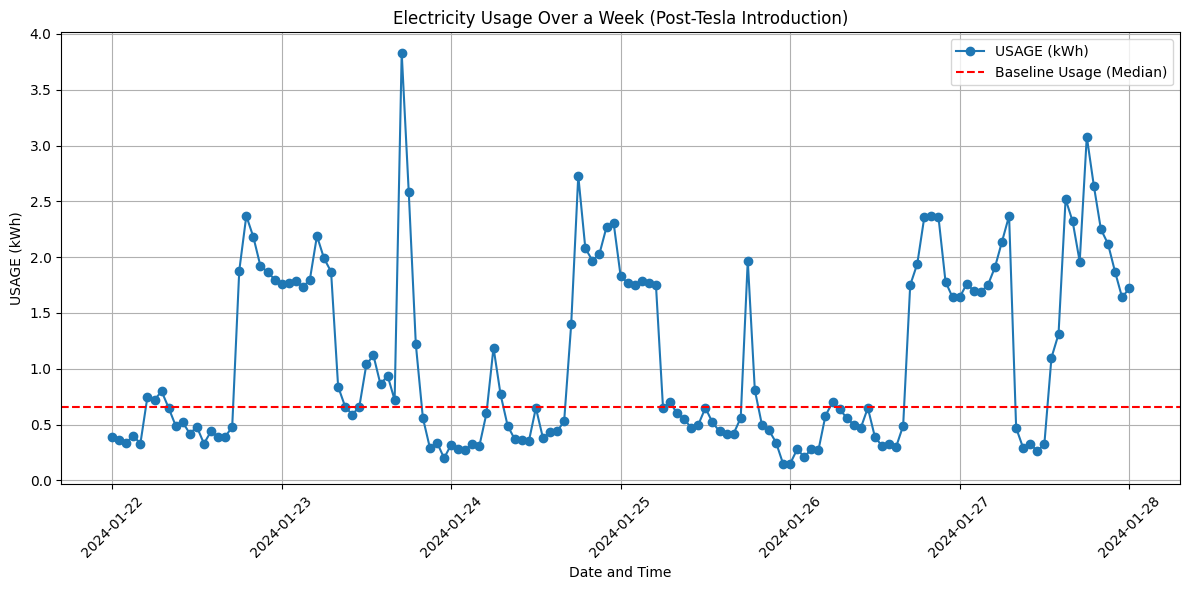

In [25]:
# Import necessary library
import matplotlib.pyplot as plt

# Ensure 'datetime' column is in datetime format
final_data['datetime'] = pd.to_datetime(final_data['datetime'])

# Filter data for a specific week (e.g., January 8–14, 2024)
week_data = final_data[(final_data['datetime'] >= '2024-01-22') & (final_data['datetime'] <= '2024-01-28')]

# Plot hourly usage for the selected week
plt.figure(figsize=(12, 6))
plt.plot(week_data['datetime'], week_data['USAGE (kWh)'], marker='o', linestyle='-', label='USAGE (kWh)')
plt.axhline(y=week_data['USAGE (kWh)'].median(), color='r', linestyle='--', label='Baseline Usage (Median)')

# Customize the plot
plt.title('Electricity Usage Over a Week (Post-Tesla Introduction)')
plt.xlabel('Date and Time')
plt.ylabel('USAGE (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()
